In [7]:
import numpy as np
import time
from visual_odometer import VisualOdometer
from tqdm import tqdm
import pandas as pd

DATA_ROOT = "../data/"

data = pd.read_pickle(DATA_ROOT + "artificial_dataset.pkl")

methods = ["svd", "proj-svd", "phase-correlation", "phase-amplified-correlation"]


In [8]:
results = {
    ("ID", "", ""): [],
    ("Method", "", ""): [],

    ("Elapsed time / (ms)", "mean", ""): [],
    ("Elapsed time / (ms)", "max", ""): [],
    ("Elapsed time / (ms)", "min", ""): [],

    ("Point wise error / (pixels)", "x-axis", "mean"): [],
    ("Point wise error / (pixels)", "x-axis", "max"): [],
    ("Point wise error / (pixels)", "x-axis", "min"): [],

    ("Point wise error / (pixels)", "y-axis", "mean"): [],
    ("Point wise error / (pixels)", "y-axis", "max"): [],
    ("Point wise error / (pixels)", "y-axis", "min"): [],

    ("Point wise error / (pixels)", "combined", "mean"): [],
    ("Point wise error / (pixels)", "combined", "max"): [],
    ("Point wise error / (pixels)", "combined", "min"): [],

    ("Cumulative error / (pixels)", "x-axis", ""): [],
    ("Cumulative error / (pixels)", "y-axis", ""): [],
    ("Cumulative error / (pixels)", "comb", ""): [],
}

estimates = {
    "ID": [],
    "Method": [],
    "x-axis": [],
    "y-axis": [],
}


In [9]:
ii = 0
for method in tqdm(methods):
    odometer = VisualOdometer(img_shape=data["img"][0].shape, xres=-1, yres=-1)
    odometer.config_displacement_estimation(method)

    odometer.feed_image(data["img"][0])
    odometer.get_displacement()
    odometer.feed_image(data["img"][1])
    odometer.get_displacement()

    t0 = time.time()
    elapsed_time = []

    nrows = len(data)
    delta_x_pred, delta_y_pred = [], []
    x_pred, y_pred = [0], [0]
    x_true, y_true = [0], [0]
    for i in range(nrows):
        order = data.iloc[i]['order']
        img = data.iloc[i]['img']

        ti0 = time.time()
        odometer.feed_image(img)

        delta_xi, delta_yi = odometer.get_displacement()
        ti1 = time.time()

        elapsed_time.append((ti1 - ti0) * 1e3)
        delta_x_pred.append(delta_xi)
        delta_y_pred.append(delta_yi)
        x_pred.append(delta_xi + x_pred[-1])
        y_pred.append(delta_yi + y_pred[-1])
        x_true.append(data["delta_x"][i] + x_true[-1])
        y_true.append(data["delta_y"][i] + y_true[-1])

    x_true, y_true = np.array(x_true), np.array(y_true)
    x_pred, y_pred = np.array(x_pred), np.array(y_pred)

    #%% Compute metrics:
    pointwise_x_error = x_true - x_pred
    pointwise_y_error = y_true - y_pred
    pointwise_comb_error = np.sqrt(pointwise_x_error ** 2 + pointwise_y_error ** 2)

    cumulative_x_error = x_pred[-1] - x_true[-1]
    cumulative_y_error = y_pred[-1] - y_true[-1]
    cumulative_comb_error = np.sqrt(cumulative_x_error ** 2 + cumulative_y_error ** 2)

    #%% Convert results into dataframe:
    ii += 1
    results[("ID", "", "")].append(ii)
    results[("Method", "", "")].append(method)

    # Elapsed time
    results[("Elapsed time / (ms)", "mean", "")].append(np.mean(elapsed_time))
    results[("Elapsed time / (ms)", "max", "")].append(np.max(elapsed_time))
    results[("Elapsed time / (ms)", "min", "")].append(np.min(elapsed_time))

    # Pointwise error (x-axis)
    results[("Point wise error / (pixels)", "x-axis", "mean")].append(np.mean(pointwise_x_error))
    results[("Point wise error / (pixels)", "x-axis", "max")].append(np.max(pointwise_x_error))
    results[("Point wise error / (pixels)", "x-axis", "min")].append(np.min(pointwise_x_error))

    # Pointwise error (y-axis)
    results[("Point wise error / (pixels)", "y-axis", "mean")].append(np.mean(pointwise_y_error))
    results[("Point wise error / (pixels)", "y-axis", "max")].append(np.max(pointwise_y_error))
    results[("Point wise error / (pixels)", "y-axis", "min")].append(np.min(pointwise_y_error))

    # Pointwise error (combined)
    results[("Point wise error / (pixels)", "combined", "mean")].append(np.mean(pointwise_comb_error))
    results[("Point wise error / (pixels)", "combined", "max")].append(np.max(pointwise_comb_error))
    results[("Point wise error / (pixels)", "combined", "min")].append(np.min(pointwise_comb_error))

    # Cumulative errors
    results[("Cumulative error / (pixels)", "x-axis", "")].append(cumulative_x_error)
    results[("Cumulative error / (pixels)", "y-axis", "")].append(cumulative_y_error)
    results[("Cumulative error / (pixels)", "comb", "")].append(cumulative_comb_error)

    #
    estimates["ID"].append(ii)
    estimates["Method"].append(method)
    estimates["x-axis"].append(x_pred)
    estimates["y-axis"].append(y_pred)

100%|██████████| 4/4 [00:19<00:00,  4.89s/it]


In [10]:
# Convert dict to DataFrame (single row per run if lists are same length)
df = pd.DataFrame(results)

# Convert columns to MultiIndex
df.columns = pd.MultiIndex.from_tuples(df.columns, names=["Category", "Axis", "Metric"])

# Print nicely rounded table
#print(df.round(4).to_string(index=False))

In [11]:
from IPython.display import display

# Just display the DataFrame directly
display(
    df.style
      .format(precision=2)
      .hide(axis='index')
)

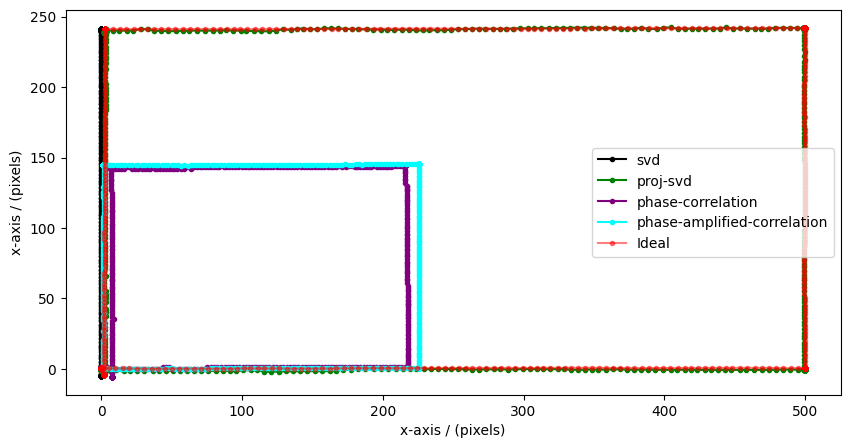

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))

colors = ['k', 'g', 'purple', 'cyan']
for i, method in enumerate(methods):
    plt.plot(estimates['x-axis'][i], estimates['y-axis'][i], '-o', color=colors[i], label=method, markersize=3)
plt.plot(x_true, y_true, '-o', markersize=3, alpha=.5, color='r', label='Ideal')
plt.xlabel("x-axis / (pixels)")
plt.ylabel("x-axis / (pixels)")
plt.legend()
plt.show()

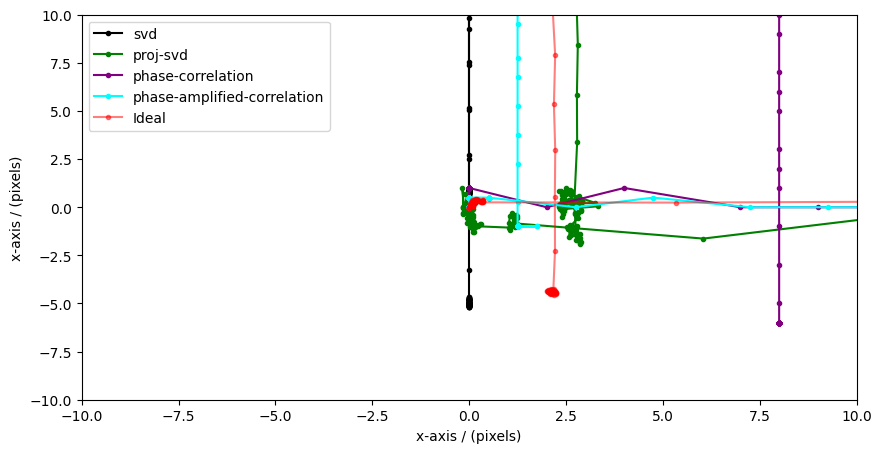

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))

colors = ['k', 'g', 'purple', 'cyan']
for i, method in enumerate(methods):
    plt.plot(estimates['x-axis'][i], estimates['y-axis'][i], '-o', color=colors[i], label=method, markersize=3)
plt.plot(x_true, y_true, '-o', markersize=3, alpha=.5, color='r', label='Ideal')
plt.xlabel("x-axis / (pixels)")
plt.ylabel("x-axis / (pixels)")
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.legend()
plt.show()